## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [1]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [2]:
#!poetry add lightgbm

In [3]:
#!poetry add pyarrow

In [4]:
#!poetry add shap

In [5]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text
import shap

/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [7]:
data_set = pd.read_feather("/home/raul/Documentos/zrive-ds/Datos/financials_against_return.feather")

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [8]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [9]:
data_set.shape

(170483, 145)

Create the target:

In [10]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [11]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [12]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [13]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [14]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":2, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

Meto en la funcion que me devuelva los shap values

In [15]:
import shap
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        shap_values = None
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values


execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [16]:
execution_dates1quarter=np.random.choice(execution_dates, size=(len(execution_dates)//4), replace=False)

In [17]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-06-30T00:00:00.000000000 due to calculation error
2005-09-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-09-30T00:00:00.000000000 due to calculation error
2005-12-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-12-30T00:00:00.000000000 due to calculation error
2006-03-31T00:00:00.000000000
Skipping SHAP values for execution date 2006-03-31T00:00:00.000000000 due to calculation error
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.

In [18]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [19]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [20]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

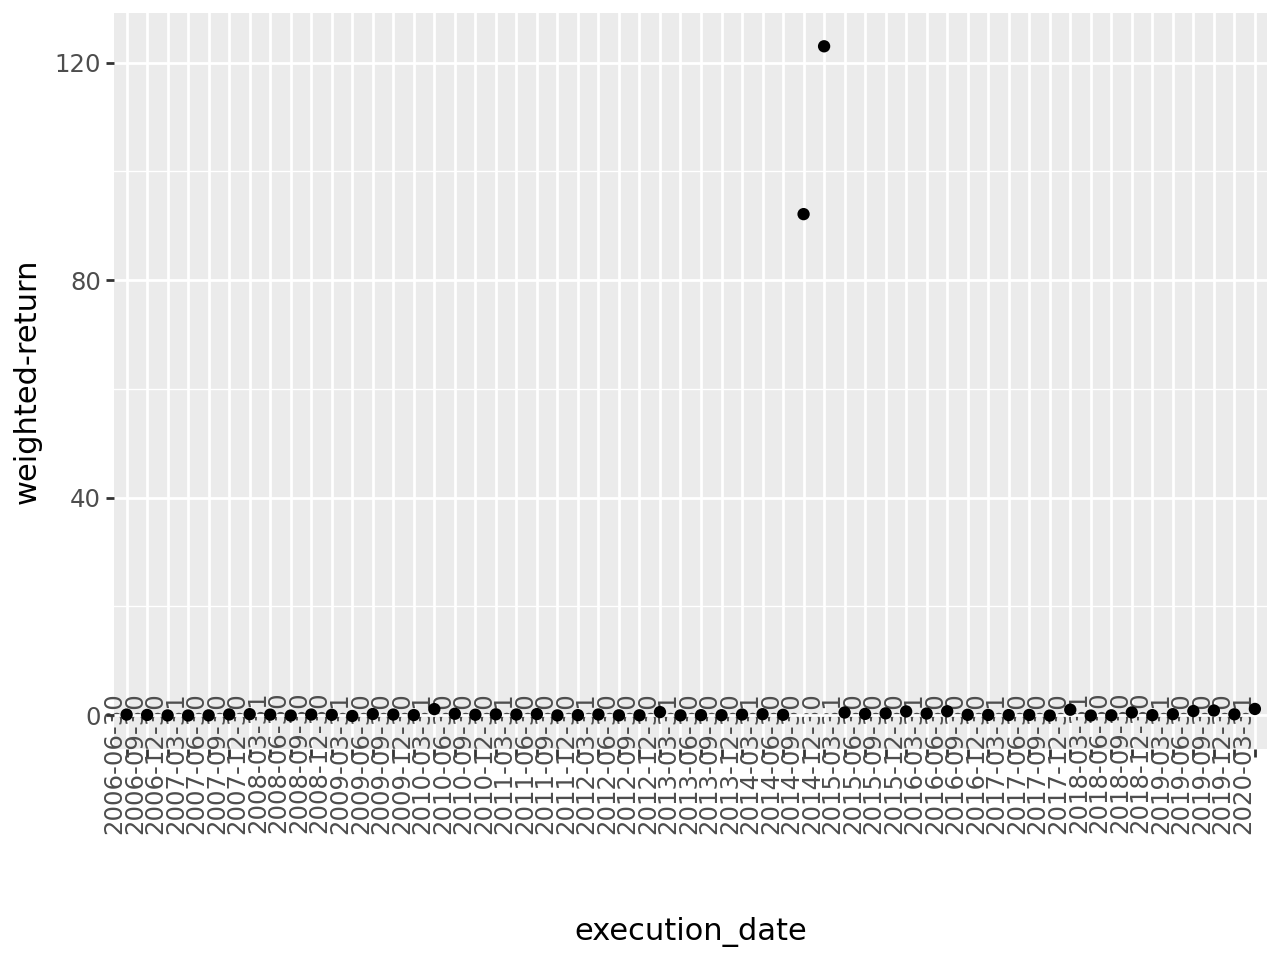

In [21]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



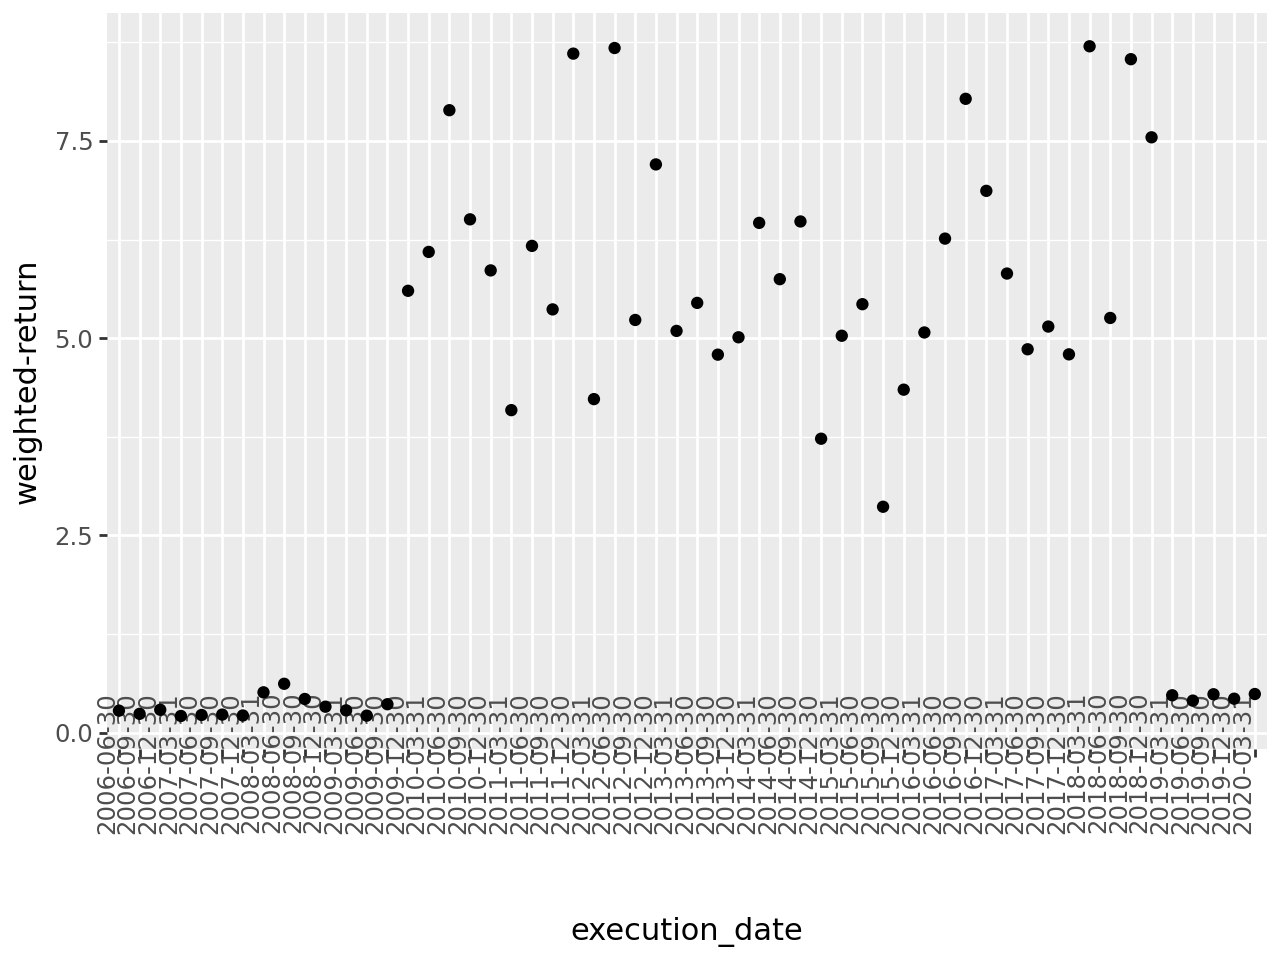

In [22]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

def plot_metrics(
        model_name, y_pred, y_test, target_precision=0.05, figure=None
):
    precision_, recall_, _ =precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _=roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax =plt.subplots(1,2,figsize=(14,7))
    else:
        fig, ax =figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()


    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()


In [70]:
import shap
def run_model_for_execution_date1(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        shap_values = None
        test_prob = None
        train_prob = None
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            test_prob=test_set['prob']
            train_prob = model.predict(X_train)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test)

            
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values, test_prob, test_set['target'], train_prob, train_set['target']


execution_dates = np.sort( data_set['execution_date'].unique() )

In [63]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

2005-06-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-06-30T00:00:00.000000000 due to calculation error
2005-09-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-09-30T00:00:00.000000000 due to calculation error
2005-12-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-12-30T00:00:00.000000000 due to calculation error
2006-03-31T00:00:00.000000000
Skipping SHAP values for execution date 2006-03-31T00:00:00.000000000 due to calculation error
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.

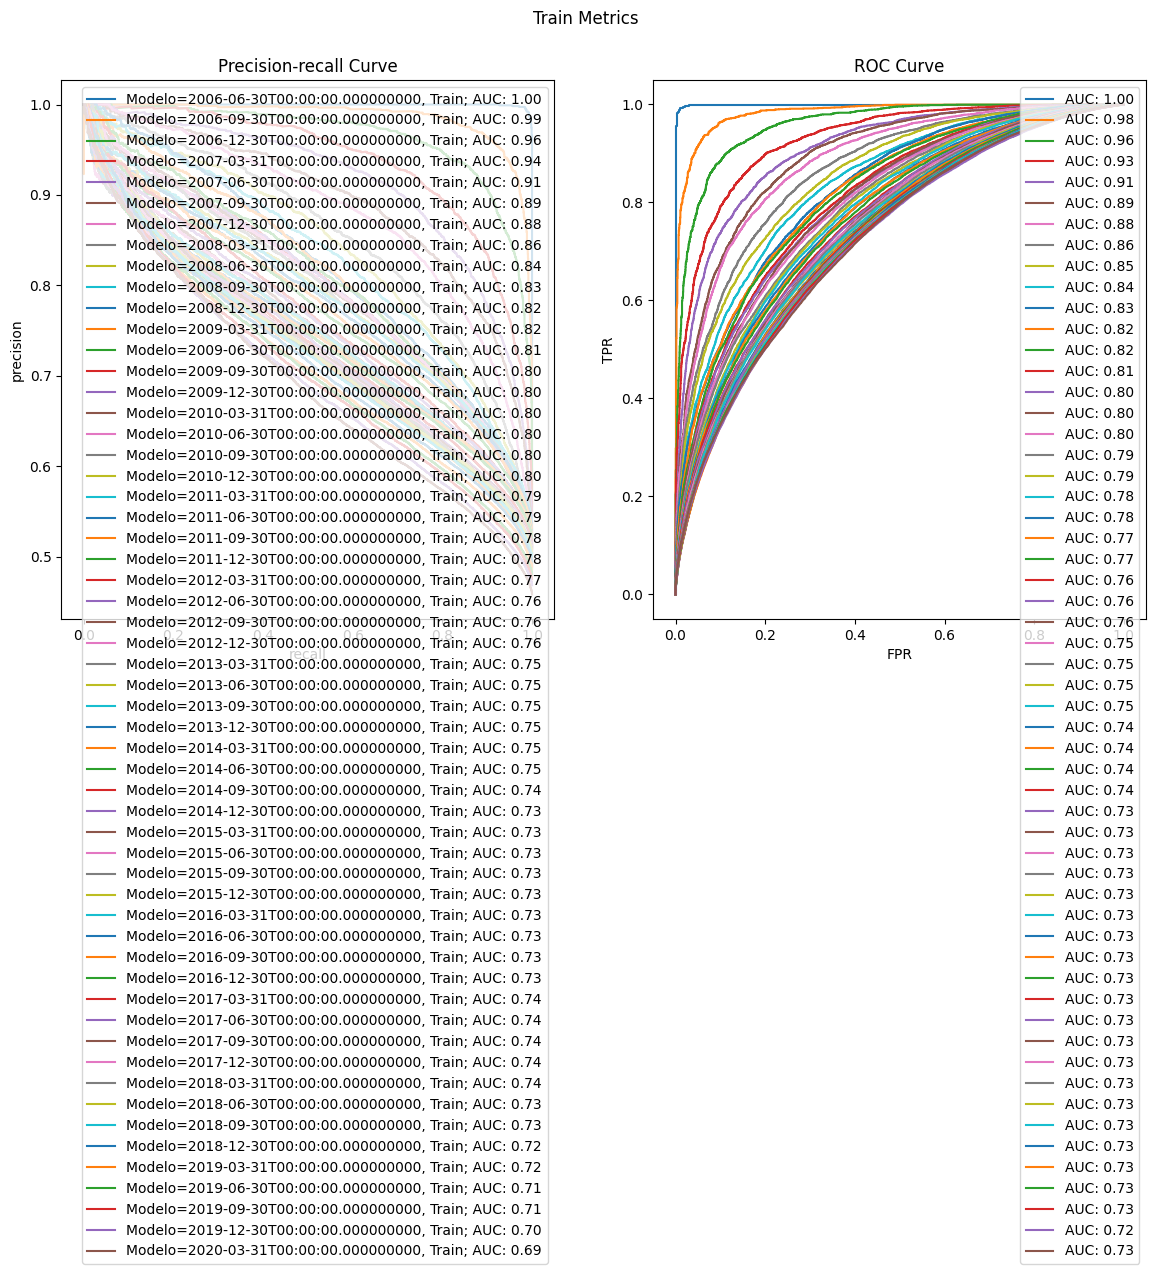

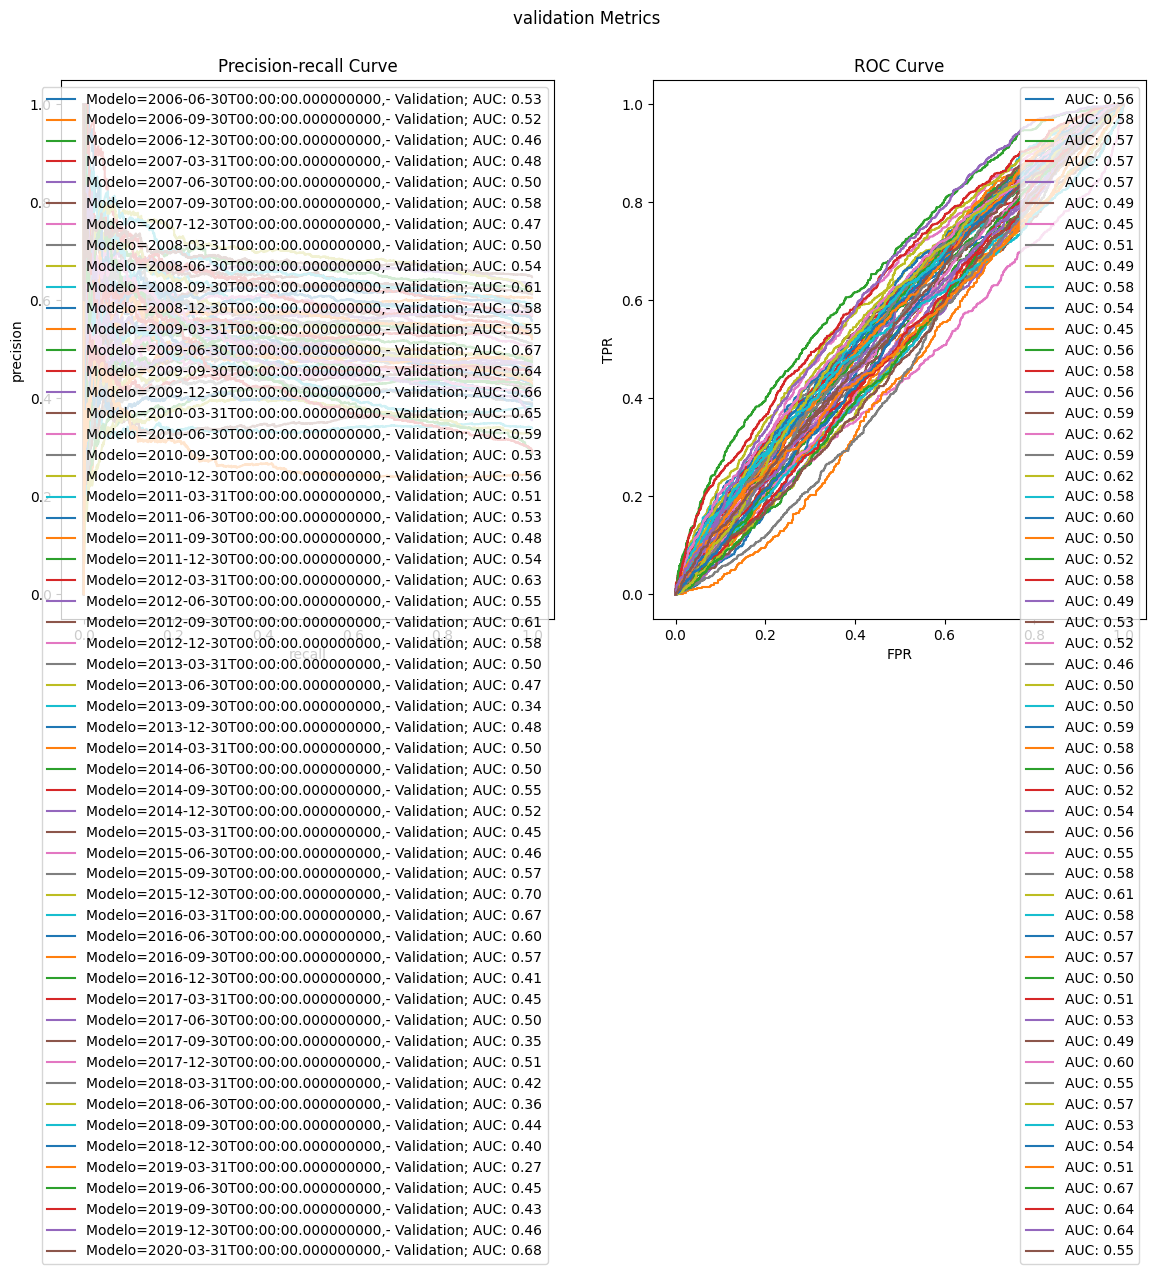

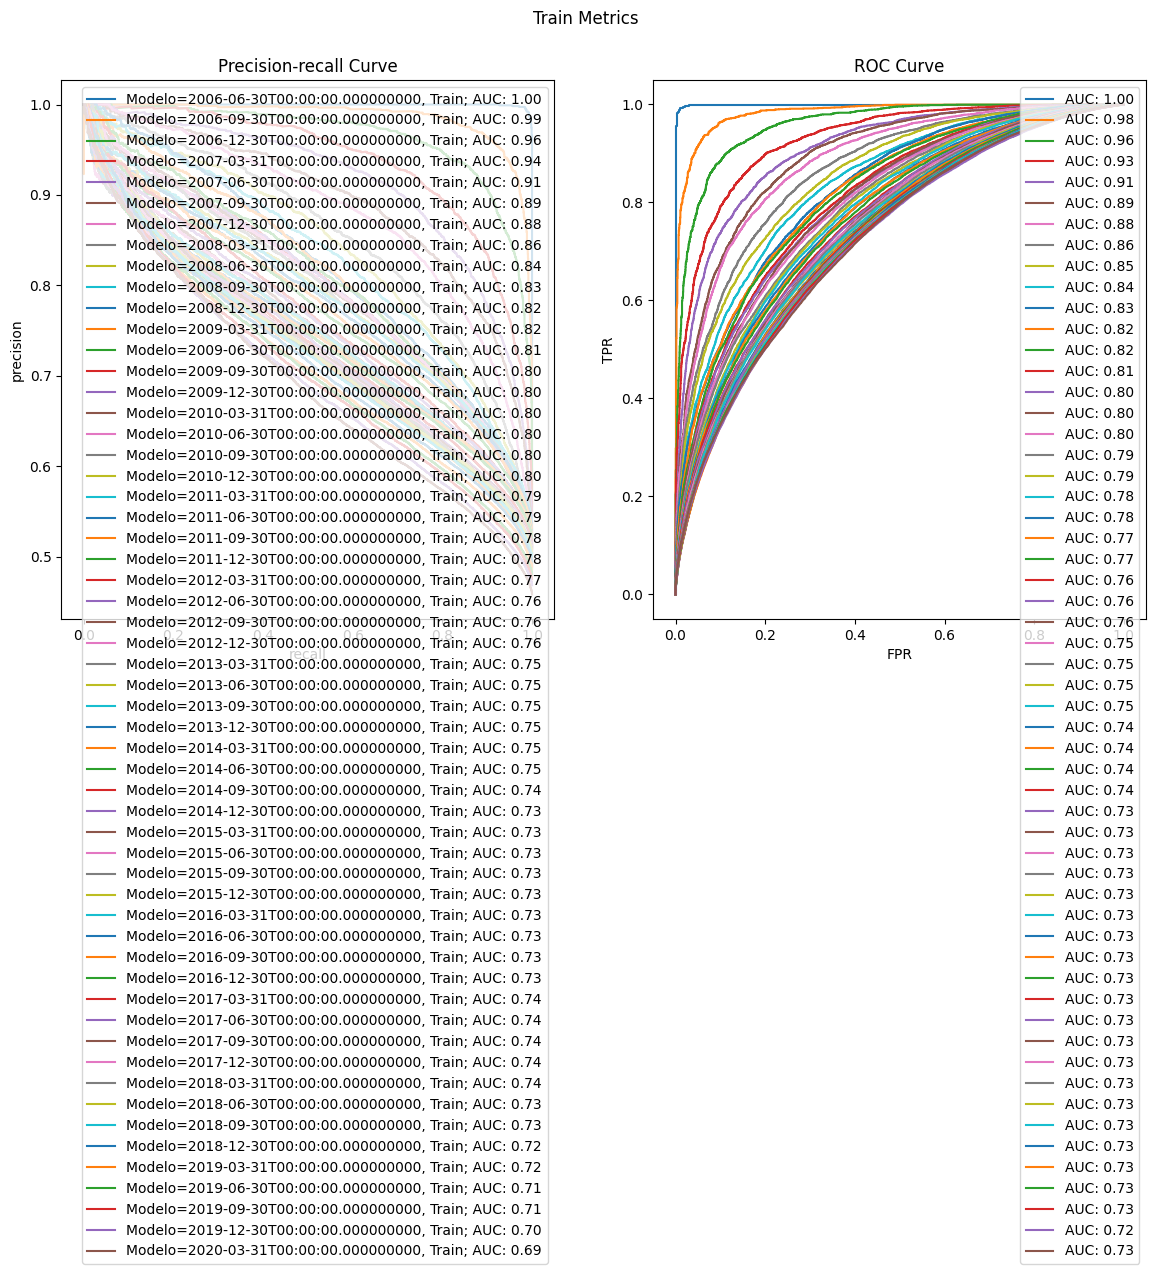

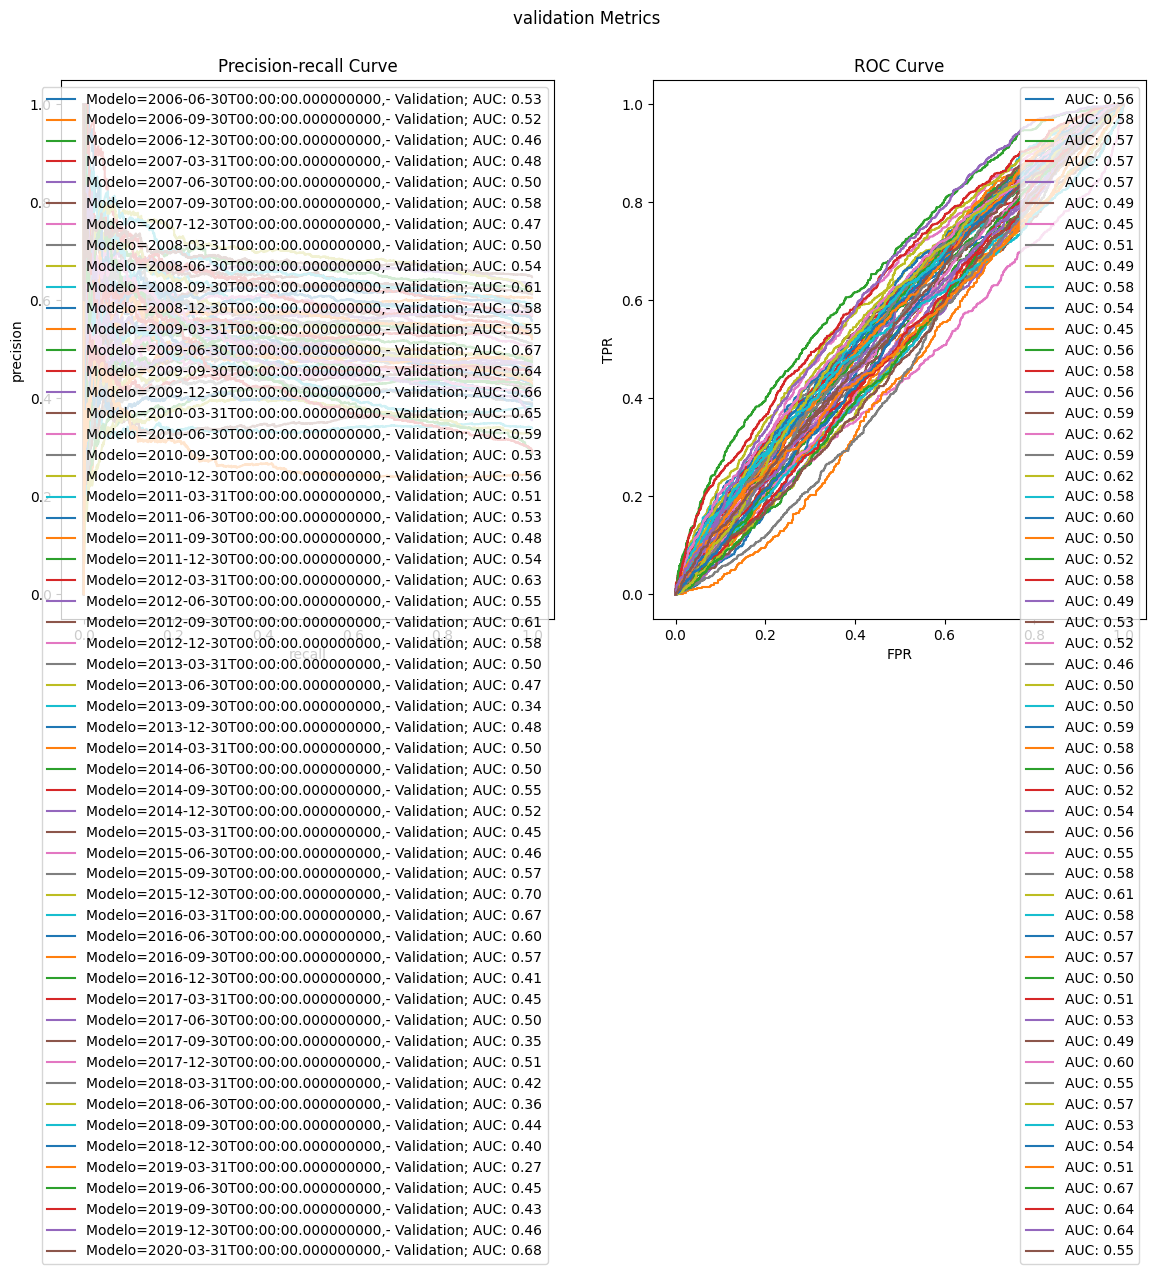

In [67]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
# Crear figuras para los gráficos
fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 7))
fig_train.suptitle("Train Metrics")
fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 7))
fig_val.suptitle("validation Metrics")
for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values, probs_val, y_val, probs_train, y_train= run_model_for_execution_date1(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if ((probs_train is not None) and (probs_val is not None) and (len(probs_train)==len(y_train)) and (len(probs_val)==len(y_val))):
            # Trazar las métricas para X_train
        plot_metrics(f"Modelo={execution_date}, Train", 
                 probs_train, y_train, figure=(fig_train, ax_train))
    
    # Trazar las métricas para X_val
        plot_metrics(f"Modelo={execution_date},- Validation", 
                 probs_val, y_val, figure=(fig_val, ax_val))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")

    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
        
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 
# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

El modelo esta claramente overfitteado, sobretodo en las primeras fechas ya quee tiene menos datos para los que entrenar

In [ ]:
# Calcular la media de las importancias de las variables
mean_feature_importances = np.mean(feature_importances, axis=0)
columns_to_remove = get_columns_to_remove()
    
X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
# Crear un DataFrame para las importancias de las variables
feature_names = X_train.columns  # Suponiendo que X_train tiene los nombres de las características
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

                         feature  importance
87                       close_0    0.216592
98       sp500_change__minus_730    0.071466
19                        EBITDA    0.050689
89              sp500_change_730    0.047723
88                 close_sp500_0    0.042931
..                           ...         ...
35   NetAcquisitionsDivestitures    0.001251
129   NetCashFlow_change_2_years    0.001230
37   NetChangeInIntangibleAssets    0.000838
53                   OtherIncome    0.000098
20                  EBITDAMargin    0.000000

[134 rows x 2 columns]


La variable close_0 tiene mas del doble de importnacia que la segunda, probaremos a hacer el modelo sin ella 

In [23]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count", "close_0"]
        
    return columns_to_remove

2005-06-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-06-30T00:00:00.000000000 due to calculation error
2005-09-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-09-30T00:00:00.000000000 due to calculation error
2005-12-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-12-30T00:00:00.000000000 due to calculation error
2006-03-31T00:00:00.000000000
Skipping SHAP values for execution date 2006-03-31T00:00:00.000000000 due to calculation error
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.

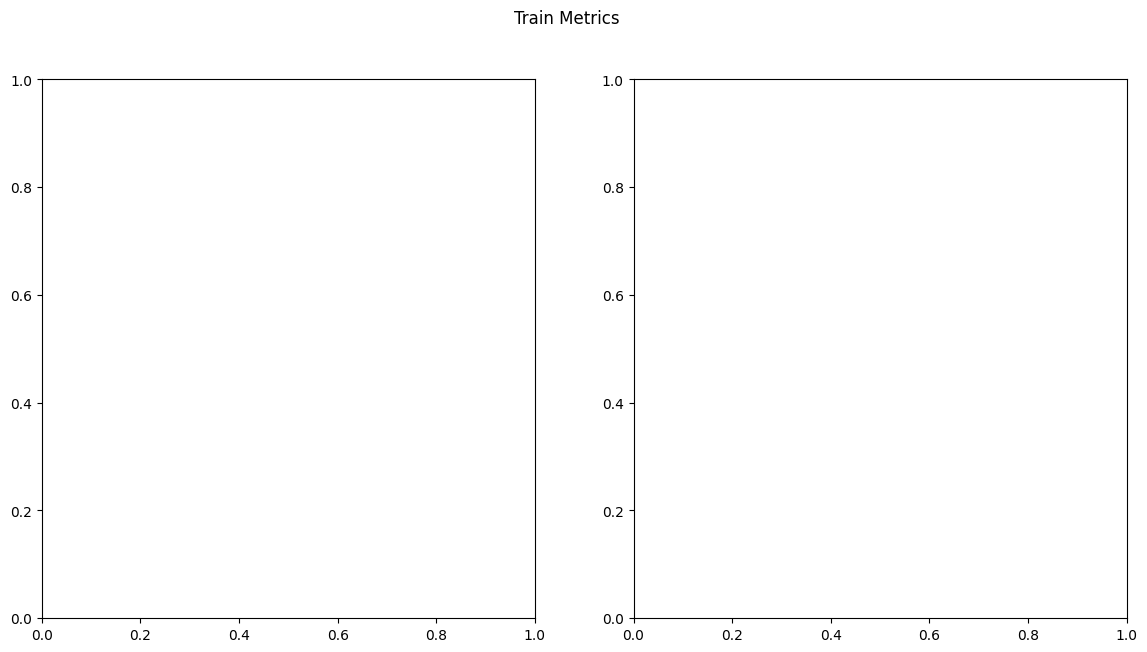

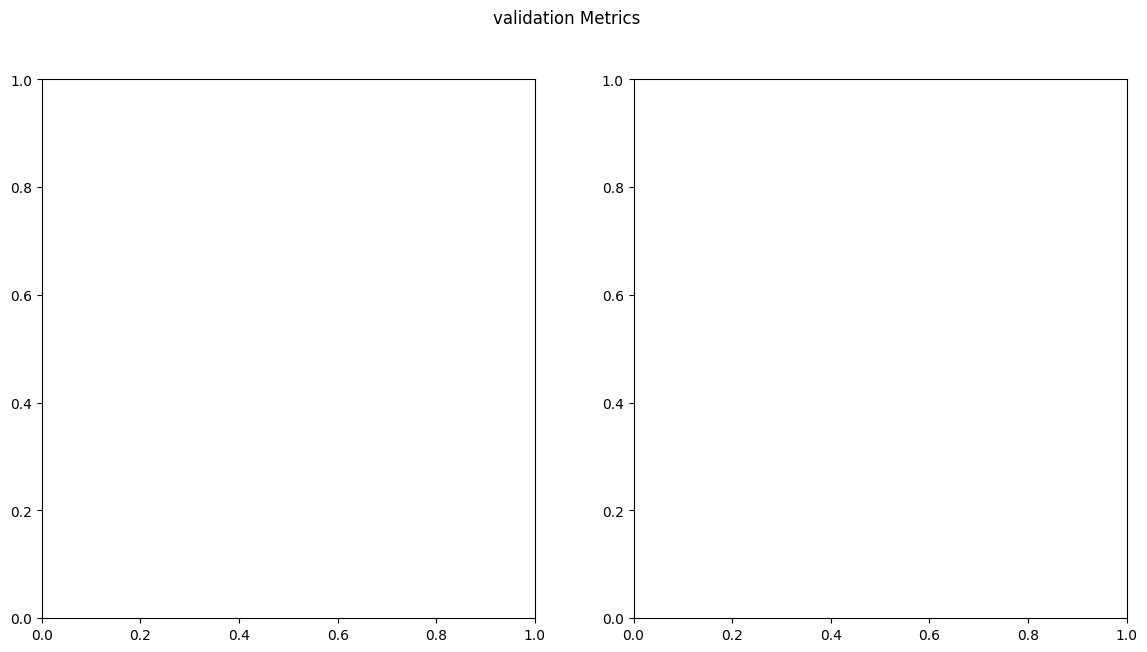

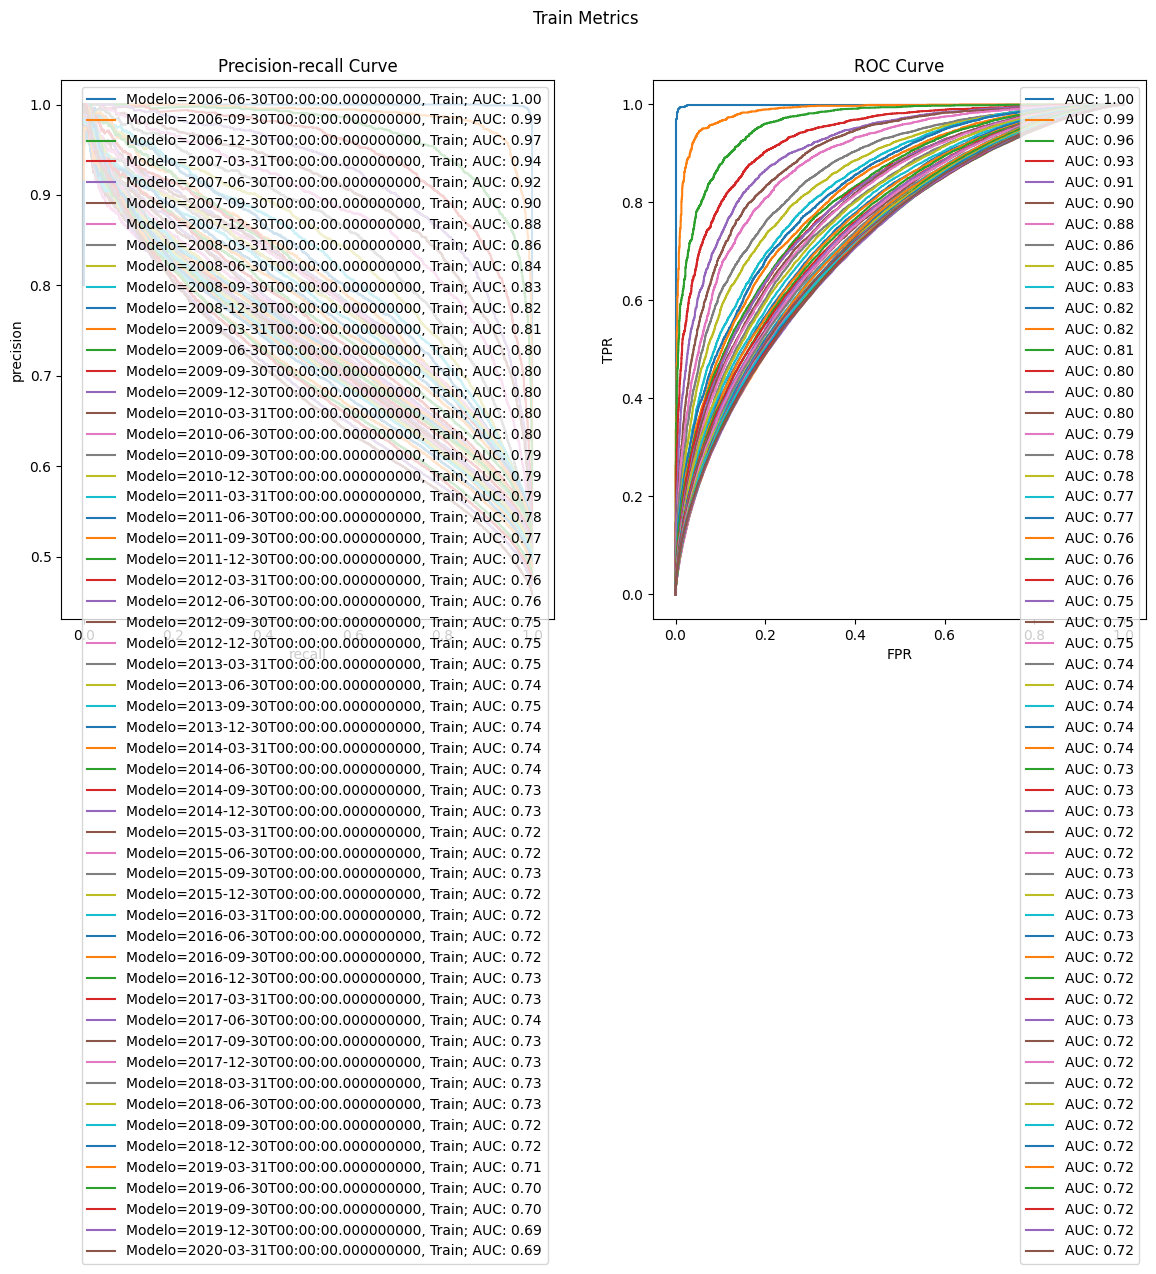

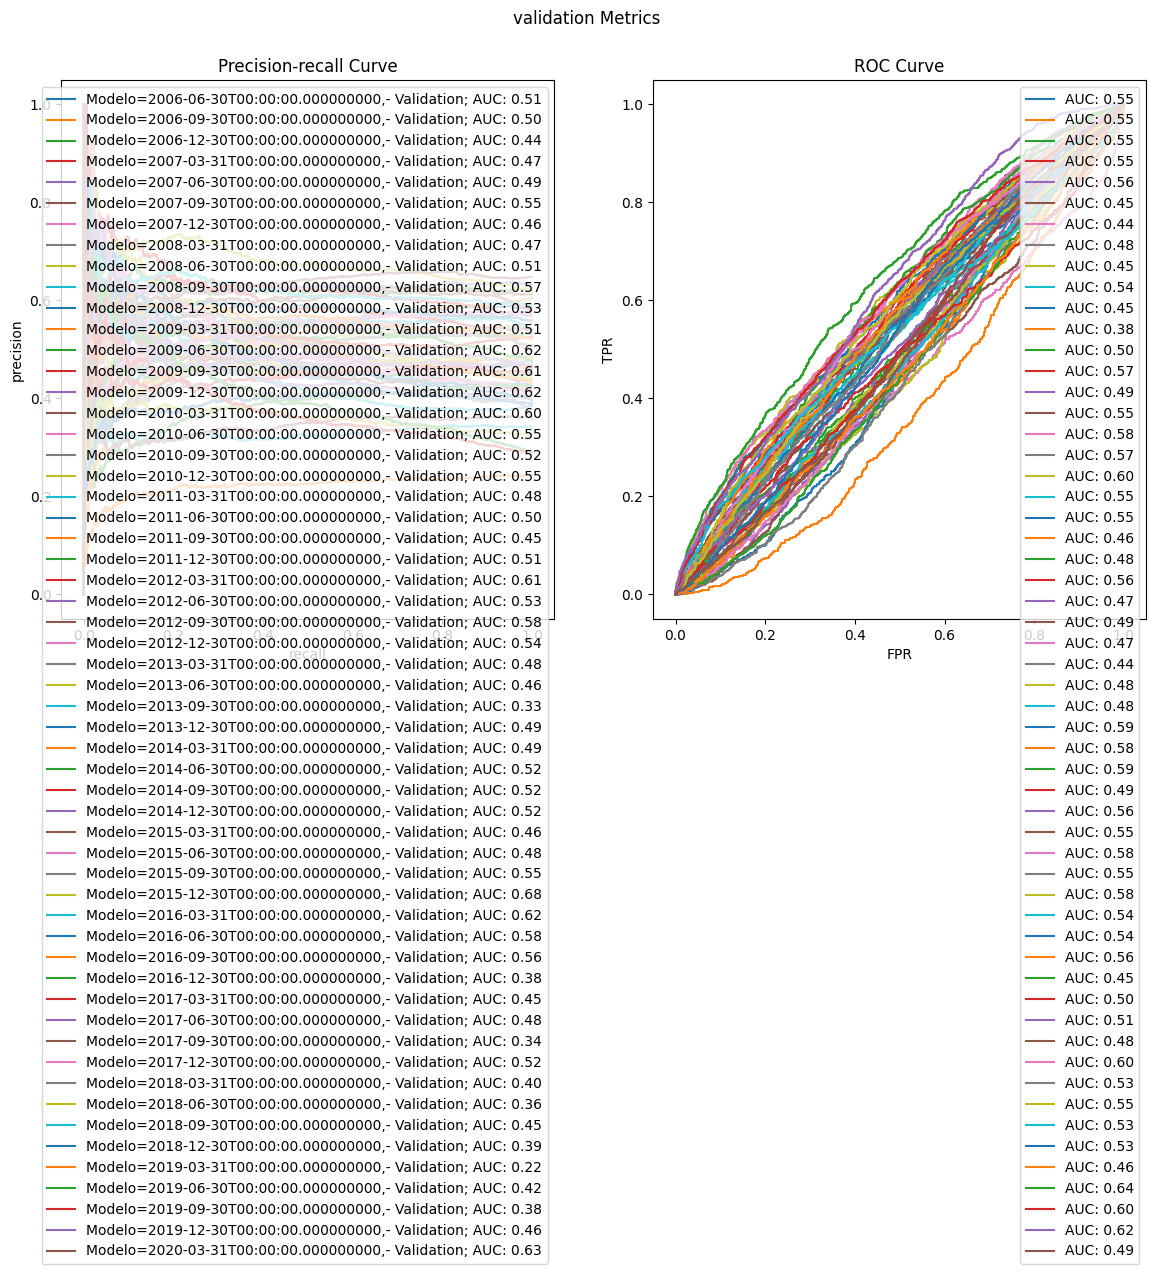

In [73]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
# Crear figuras para los gráficos
fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 7))
fig_train.suptitle("Train Metrics")
fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 7))
fig_val.suptitle("validation Metrics")
for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values, probs_val, y_val, probs_train, y_train= run_model_for_execution_date1(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if ((probs_train is not None) and (probs_val is not None) and (len(probs_train)==len(y_train)) and (len(probs_val)==len(y_val))):
            # Trazar las métricas para X_train
        plot_metrics(f"Modelo={execution_date}, Train", 
                 probs_train, y_train, figure=(fig_train, ax_train))
    
    # Trazar las métricas para X_val
        plot_metrics(f"Modelo={execution_date},- Validation", 
                 probs_val, y_val, figure=(fig_val, ax_val))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")

    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
        
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 
# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [25]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [26]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


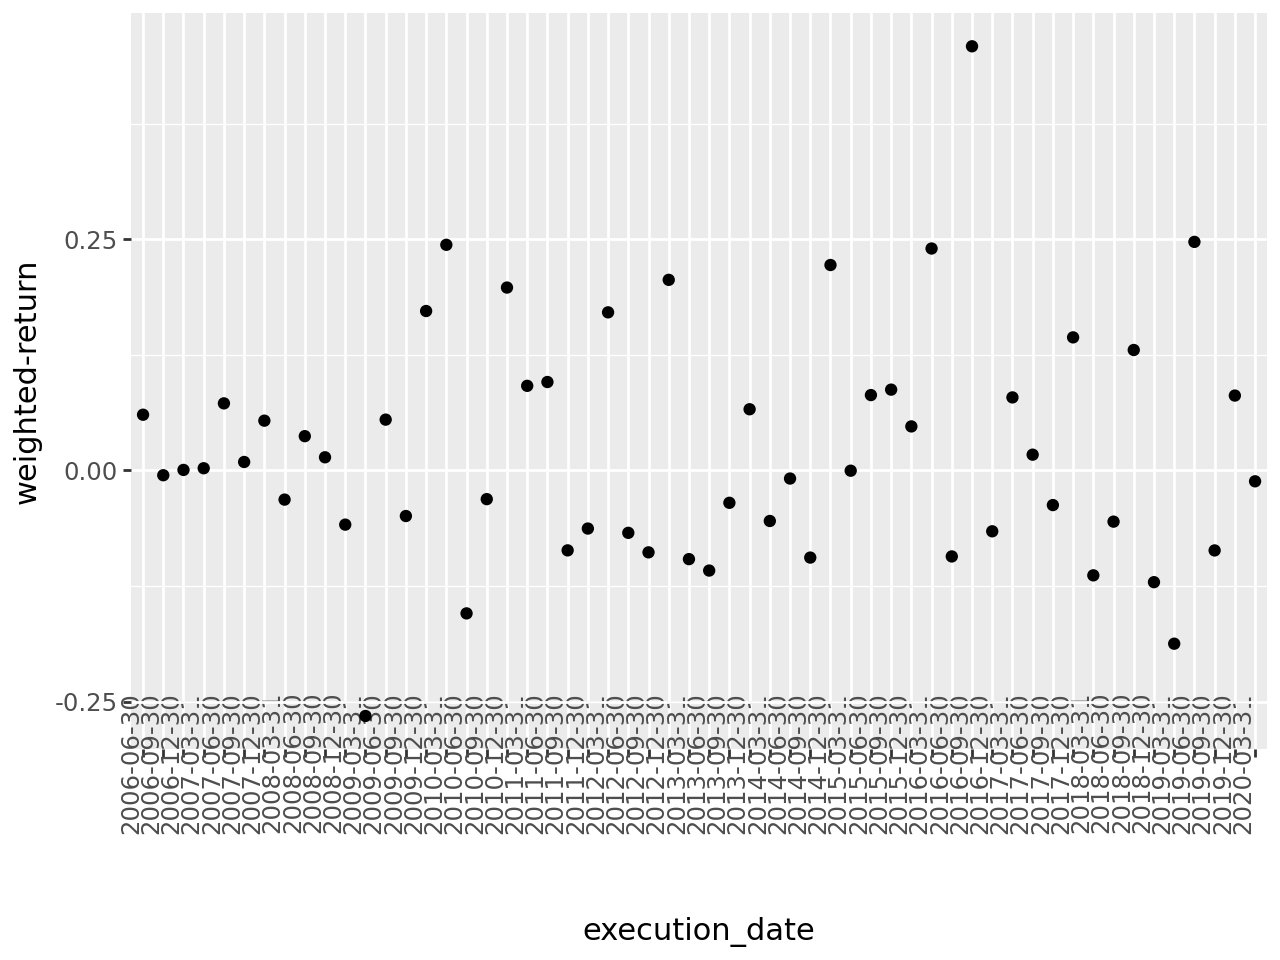

In [27]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



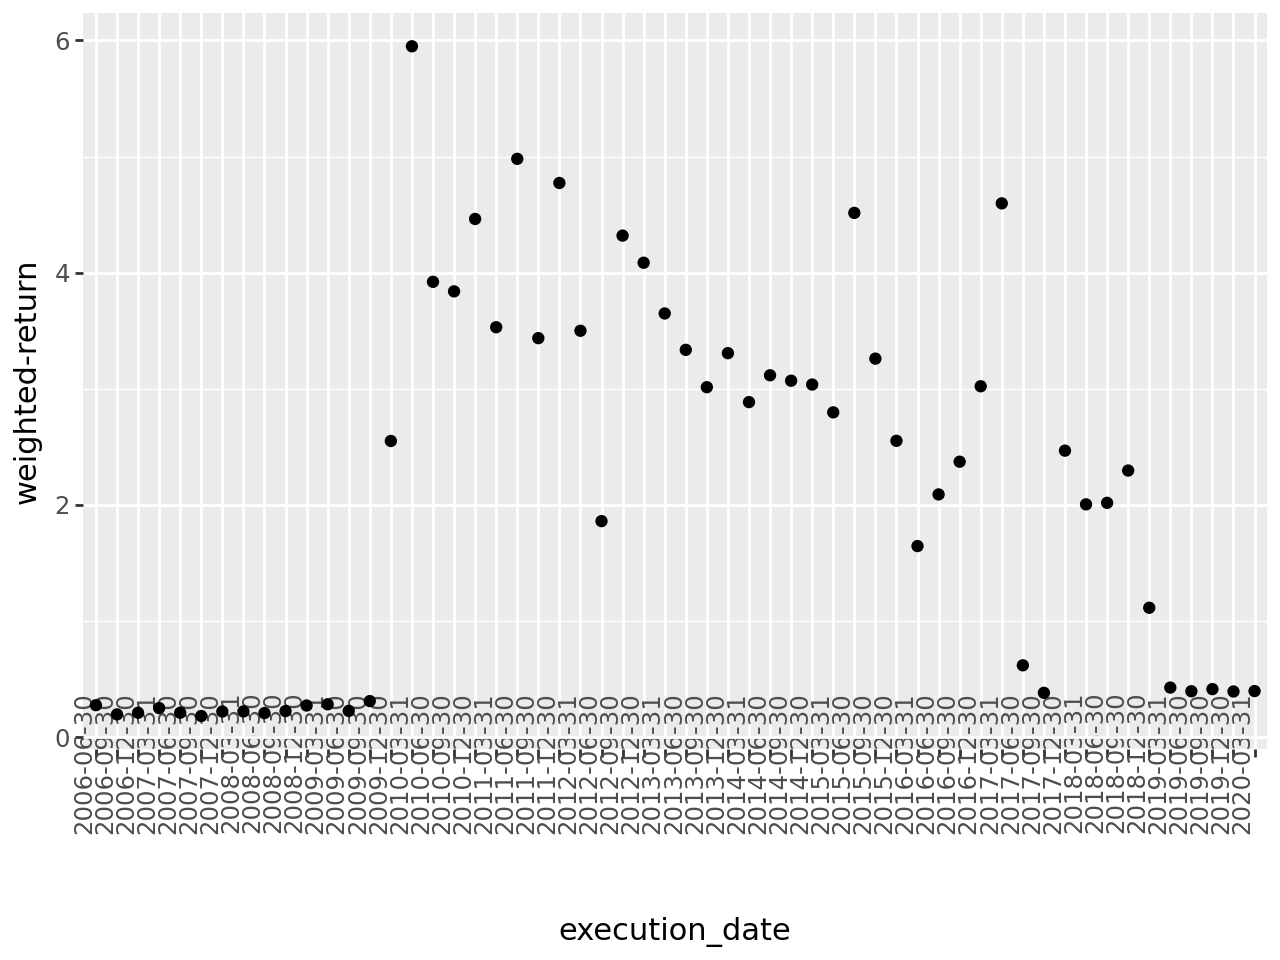

In [28]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


El rendimiento en validacion es mucho peor sin close_0

In [ ]:
# Calcular la media de las importancias de las variables
mean_feature_importances = np.mean(feature_importances, axis=0)
columns_to_remove = get_columns_to_remove()
    
X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
# Crear un DataFrame para las importancias de las variables
feature_names = X_train.columns  # Suponiendo que X_train tiene los nombres de las características
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

                        feature  importance
97      sp500_change__minus_730    0.069060
87                close_sp500_0    0.067501
88             sp500_change_730    0.048200
98               std__minus_120    0.037006
19                       EBITDA    0.034874
..                          ...         ...
35  NetAcquisitionsDivestitures    0.001156
44                    NetIncome    0.001116
37  NetChangeInIntangibleAssets    0.000572
53                  OtherIncome    0.000243
20                 EBITDAMargin    0.000000

[133 rows x 2 columns]


Buscamos que observaciones son las que mas influye la variable 'close_0'

In [34]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

In [ ]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-06-30T00:00:00.000000000 due to calculation error
2005-09-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-09-30T00:00:00.000000000 due to calculation error
2005-12-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-12-30T00:00:00.000000000 due to calculation error
2006-03-31T00:00:00.000000000
Skipping SHAP values for execution date 2006-03-31T00:00:00.000000000 due to calculation error
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.

In [53]:
print(len(shap_values_list[0]))

2050


In [29]:
columns_to_remove=get_columns_to_remove()
X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
print(X_train.columns.get_loc("close_0"))

87


In [58]:
for i in range(len(shap_values_list)):
    for j in range(len(shap_values_list[i])):
        if (shap_values_list[i][j][87])>1.2:
            print(f"Numero entrenamiento{i}, numero observacion{j}, {shap_values_list[i][j][87]}")



Numero entrenamiento15, numero observacion431, 1.3268244617041038
Numero entrenamiento15, numero observacion1432, 1.4286086053507308
Numero entrenamiento16, numero observacion12, 1.2315024336574736
Numero entrenamiento16, numero observacion17, 1.2112104841006368
Numero entrenamiento16, numero observacion640, 1.3207661988845443
Numero entrenamiento16, numero observacion1237, 1.2585641345390428
Numero entrenamiento16, numero observacion1371, 1.2747957355586417
Numero entrenamiento16, numero observacion1942, 1.2597264841600682
Numero entrenamiento16, numero observacion2048, 1.2601172510267127
Numero entrenamiento17, numero observacion446, 1.2274243604819977
Numero entrenamiento17, numero observacion1012, 1.2600268515374895
Numero entrenamiento17, numero observacion1162, 1.2788520507456371
Numero entrenamiento18, numero observacion2044, 1.3356497330495332
Numero entrenamiento48, numero observacion195, 1.2281384013919032
Numero entrenamiento48, numero observacion1577, 1.2693495762780544
Num

In [79]:
fecha=execution_dates[16]
print(fecha)

2009-06-30T00:00:00.000000000


In [80]:
test_set = data_set.loc[(data_set["execution_date"] == fecha)]
test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')

In [89]:
test_set.iloc[640,]

Ticker                                             CIR
date                               2009-03-31 00:00:00
AssetTurnover                                   0.3039
CashFlowFromFinancialActivities                  6.081
CashFlowFromInvestingActivities                -12.381
                                          ...         
Market_cap__minus_365                        826.55928
Market_cap__minus_730                        668.42919
diff_ch_sp500                                -0.031368
count                                             2240
target                                             0.0
Name: 35884, Length: 146, dtype: object

In [82]:
df_SEIC= data_set.loc[data_set['Ticker'].str.contains('BR')]

In [90]:
df_MVO= data_set.loc[data_set['Ticker'].str.contains('CIR')]

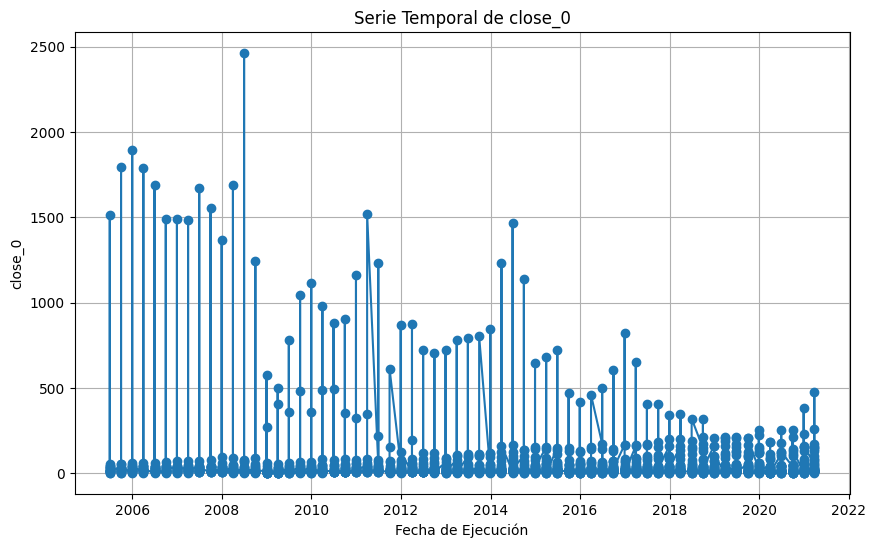

In [83]:
import pandas as pd
import matplotlib.pyplot as plt


# Convertir la columna 'execution_date' a tipo datetime
df_SEIC['execution_date'] = pd.to_datetime(df_SEIC['execution_date'])

# Establecer 'execution_date' como el índice del DataFrame
df_SEIC.set_index('execution_date', inplace=True)

# Graficar la serie temporal de 'close_0'
plt.figure(figsize=(10, 6))
plt.plot(df_SEIC.index, df_SEIC['close_0'], marker='o')
plt.title('Serie Temporal de close_0')
plt.xlabel('Fecha de Ejecución')
plt.ylabel('close_0')
plt.grid(True)
plt.show()

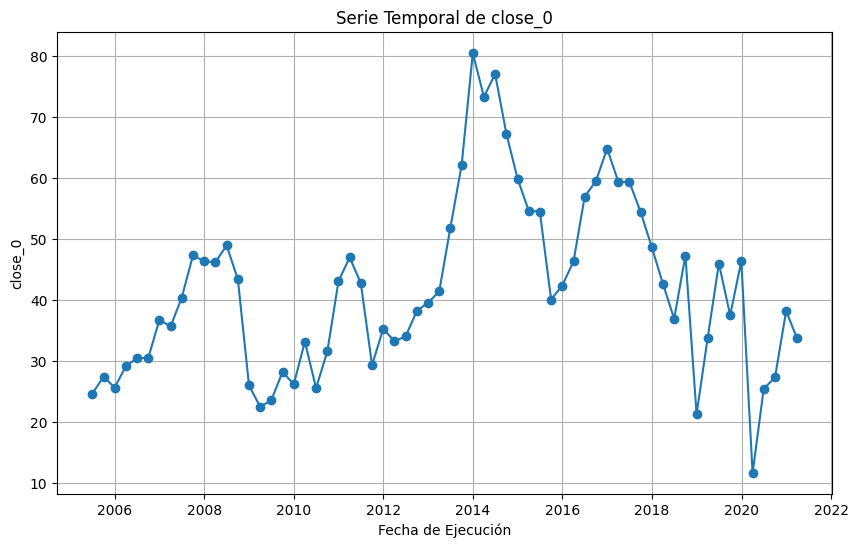

In [91]:
import pandas as pd
import matplotlib.pyplot as plt


# Convertir la columna 'execution_date' a tipo datetime
df_MVO['execution_date'] = pd.to_datetime(df_MVO['execution_date'])

# Establecer 'execution_date' como el índice del DataFrame
df_MVO.set_index('execution_date', inplace=True)

# Graficar la serie temporal de 'close_0'
plt.figure(figsize=(10, 6))
plt.plot(df_MVO.index, df_MVO['close_0'], marker='o')
plt.title('Serie Temporal de close_0')
plt.xlabel('Fecha de Ejecución')
plt.ylabel('close_0')
plt.grid(True)
plt.show()

Training only 1 quarter per year

In [ ]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
for execution_date in execution_dates1quarter:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

Meto un id en cada empresa para saber si el algoritmo overfittea

In [35]:
#Creo un diccionario para mapear cada ticker a un ID numérico único
unique_tickers = data_set['Ticker'].unique()
ticker_to_id = {ticker: idx for idx, ticker in enumerate(unique_tickers)}

#Creao una nueva columna de IDs numéricos basada en el diccionario
data_set['Ticker_ID'] = data_set['Ticker'].map(ticker_to_id)



In [36]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-06-30T00:00:00.000000000 due to calculation error
2005-09-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-09-30T00:00:00.000000000 due to calculation error
2005-12-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-12-30T00:00:00.000000000 due to calculation error
2006-03-31T00:00:00.000000000
Skipping SHAP values for execution date 2006-03-31T00:00:00.000000000 due to calculation error
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.

In [37]:
# Calcular la media de las importancias de las variables
mean_feature_importances = np.mean(feature_importances, axis=0)
columns_to_remove = get_columns_to_remove()
    
X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
# Crear un DataFrame para las importancias de las variables
feature_names = X_train.columns  # Suponiendo que X_train tiene los nombres de las características
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

                        feature  importance
87                      close_0    0.219826
98      sp500_change__minus_730    0.068088
88                close_sp500_0    0.064805
19                       EBITDA    0.047799
99               std__minus_120    0.046401
..                          ...         ...
36                  NetCashFlow    0.001179
35  NetAcquisitionsDivestitures    0.000931
37  NetChangeInIntangibleAssets    0.000931
53                  OtherIncome    0.000157
20                 EBITDAMargin    0.000000

[135 rows x 2 columns]


Ticker_id no tiene poder predictivo

Miramos el log loss para lso diferentes modelos y numero de arboles

In [24]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-06-30T00:00:00.000000000 due to calculation error
2005-09-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-09-30T00:00:00.000000000 due to calculation error
2005-12-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-12-30T00:00:00.000000000 due to calculation error
2006-03-31T00:00:00.000000000
Skipping SHAP values for execution date 2006-03-31T00:00:00.000000000 due to calculation error
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.

In [44]:
def return_learning_curves(all_results, set):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [45]:
train_learning_curve=return_learning_curves(all_results, "training")

In [47]:
train_learning_curve['tree_categorical']=pd.Categorical(train_learning_curve['n_trees'], categories=train_learning_curve['n_trees'].unique())

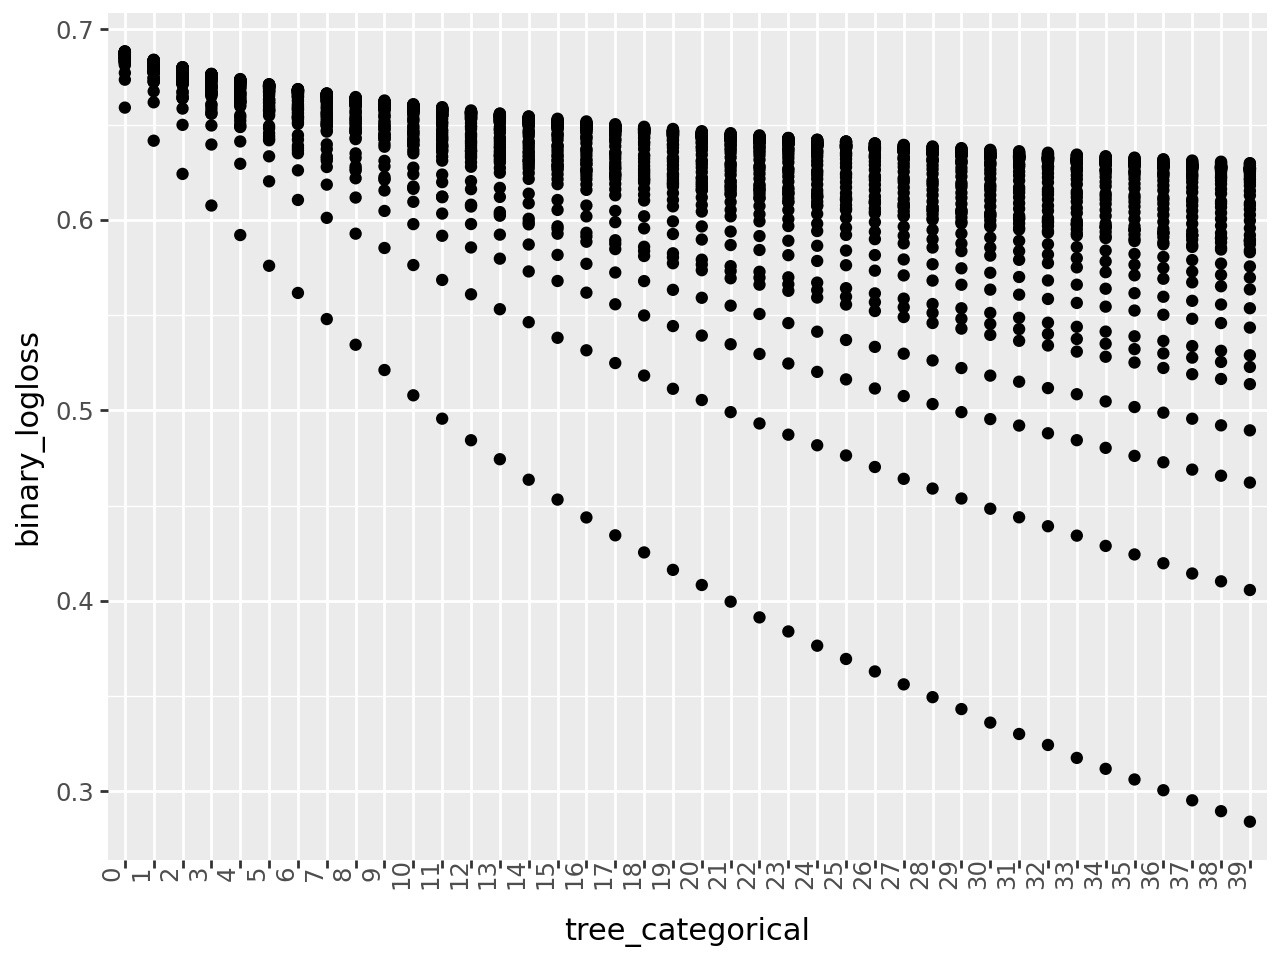

In [53]:
#print (train_learning_curve)
ggplot(train_learning_curve) + geom_point(aes(x = "tree_categorical", y = "binary_logloss")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [56]:
valid_learning_curve=return_learning_curves(all_results, "valid_0")

In [59]:
valid_learning_curve['tree_categorical']=pd.Categorical(valid_learning_curve['n_trees'], categories=valid_learning_curve['n_trees'].unique())

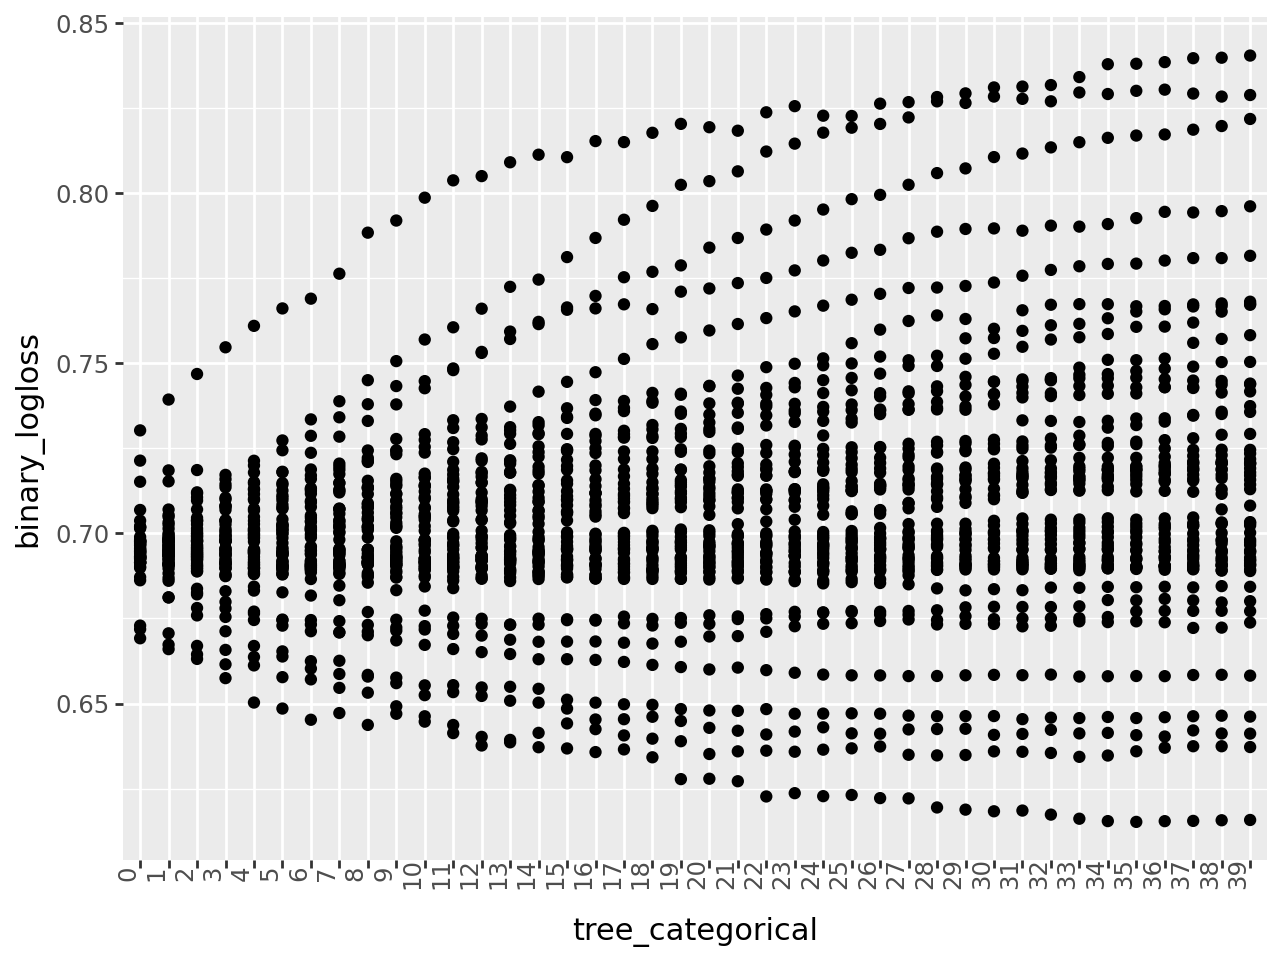

In [60]:
#print (train_learning_curve)
ggplot(valid_learning_curve) + geom_point(aes(x = "tree_categorical", y = "binary_logloss")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0.5,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0.5,"target"] = 0

data_set["target"].value_counts()

target
0.0    140855
1.0     15411
Name: count, dtype: int64

In [61]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count","close_0", "Ticker_id"]
        
    return columns_to_remove

In [62]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
shap_values_list = []
# Acumular importancias de variables
feature_importances = []
for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, shap_values = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    if shap_values is not None:
        shap_values_list.append(shap_values.values)
        feature_importances.append(np.abs(shap_values.values).mean(axis=0))
    else:
        print(f"Skipping SHAP values for execution date {execution_date} due to calculation error")
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-06-30T00:00:00.000000000 due to calculation error
2005-09-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-09-30T00:00:00.000000000 due to calculation error
2005-12-30T00:00:00.000000000
Skipping SHAP values for execution date 2005-12-30T00:00:00.000000000 due to calculation error
2006-03-31T00:00:00.000000000
Skipping SHAP values for execution date 2006-03-31T00:00:00.000000000 due to calculation error
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.

In [58]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [59]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

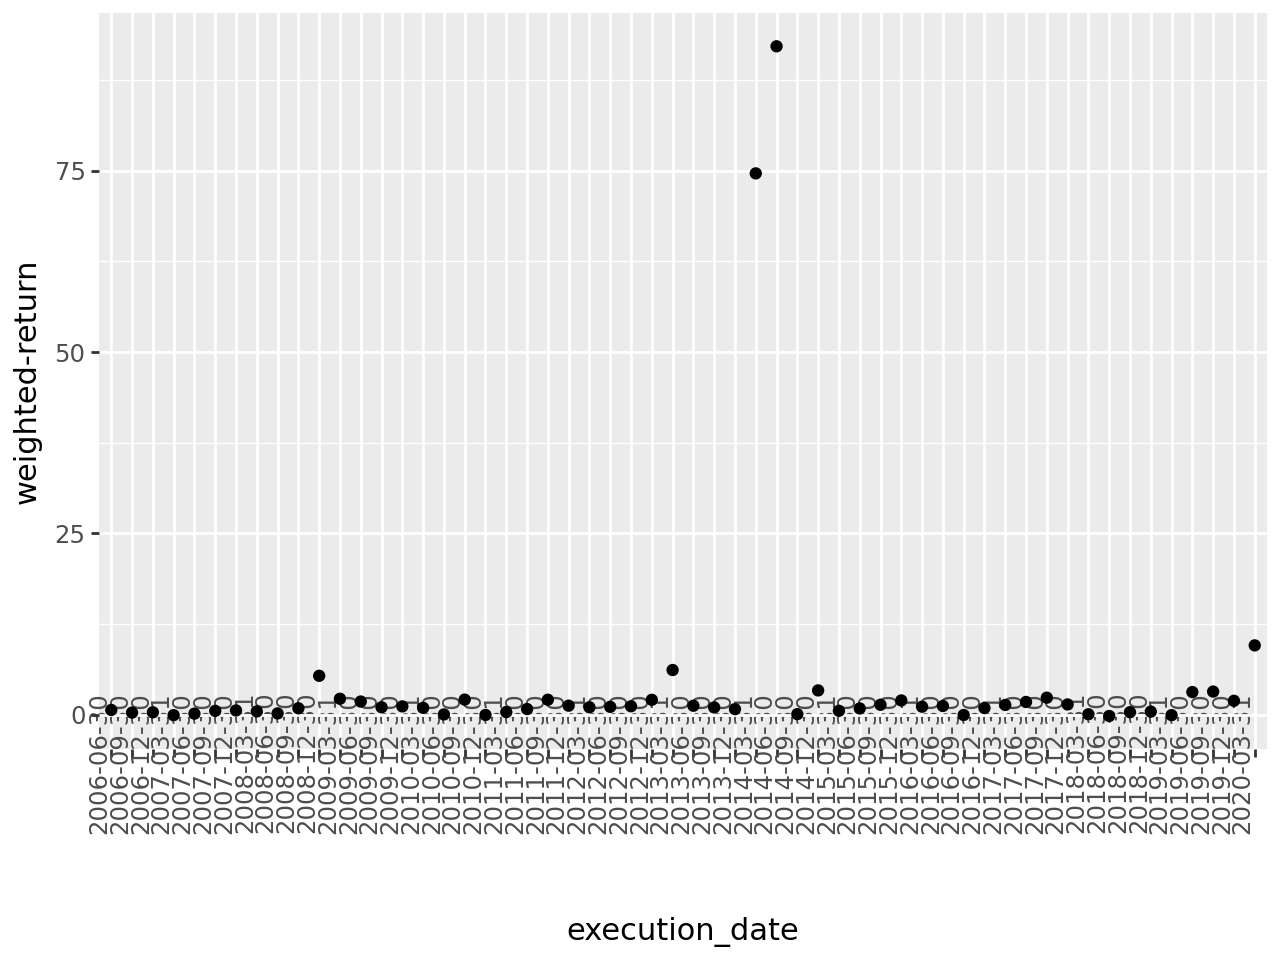

In [60]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

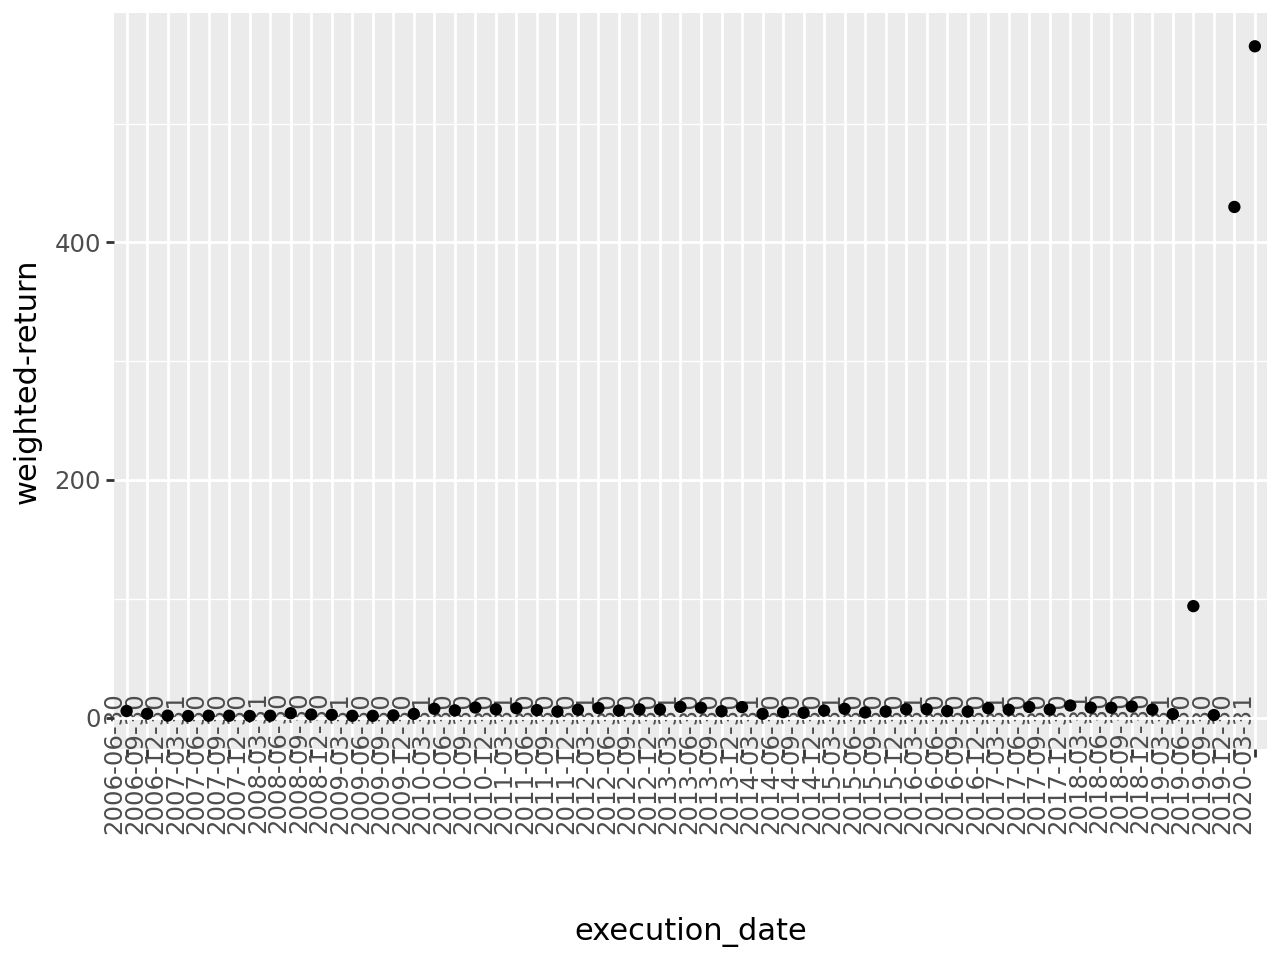

In [61]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))